In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json


In [5]:
import proteomics_functions as prot_fun

sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

sys.path.append("/home/chase/my_work/correlation_aex_data/mean_field_electrostatics/v2")
import base_classes
import morbidelli as m

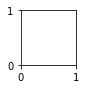

In [6]:
fig, ax = my_plot.instantiate_fig(1, 1)

# Load SWATH data
- Everything was analyzed with the native digest (except for the HCCF LMW 2 sample)

In [7]:
dfs = Dict()
dfs_mab = Dict()

file = pd.ExcelFile('./data/Chase SWATH 20220830.xlsx')
dfs.hccf.feed  = file.parse('HCCF-Feed')
dfs.hccf.large = file.parse('HCCF-LrgAgg')
dfs.hccf.small = file.parse('HCCF-SmAgg')
dfs.hccf.mab   = file.parse('HCCF-mAb')
dfs.hccf.spf1  = file.parse('HCCF-LMW1')
dfs.hccf.spf2  = file.parse('HCCF-LMW2') 
dfs.pavin.feed  = file.parse('PAFVIN-Feed')
dfs.pavin.large = file.parse('PAFVIN-LrgAgg')
dfs.pavin.small = file.parse('PAFVIN-SmAgg')

file = pd.ExcelFile('./data/Chase SWATH 20221128.xlsx')
dfs.pavin.mab = file.parse('PAFVIN mAb!')

# Process

In [8]:
for feed in ['hccf', 'pavin']:
    for frac in dfs[feed].keys():
        dfs[feed][frac].columns = ['accn', 'name', 'rep1_log2_norm_area', 'rep2_log2_norm_area', 'rep3_log2_norm_area', 'prot_mw', 'rep1_ng', 'rep2_ng', 'rep3_ng', 'ave_ng', 'cv']
        if frac == 'spf2':
            dfs[feed][frac]['ave_ppm'] = dfs[feed][frac]['ave_ng']/5.0 * 1e3 # x ng/5 ug * 1e-3 ug/ng * 1e6 ppm
        else:
            dfs[feed][frac]['ave_ppm'] = dfs[feed][frac]['ave_ng']/90.91 * 1e3 # x ng/90.91 ug * 1e-3 ug/ng * 1e6 ppm
                    
        # Get mAb as a separate df
        dfs_mab[feed][frac] = dfs[feed][frac][dfs[feed][frac]['name'].str.contains('Custom')]
        dfs_mab[feed][frac].reset_index(inplace=True, drop=True)
        
        # Select only CHO HCPs
        dfs[feed][frac] = dfs[feed][frac][dfs[feed][frac]['name'].str.contains('Cricetulus griseus')]
        dfs[feed][frac].reset_index(inplace=True, drop=True)

## ELISA comparison

In [32]:
df_totals = pd.read_csv('./generated_tables/elisa_and_bradford_data.csv')

In [33]:
for feed in ['hccf', 'pavin']:
    for frac in dfs[feed].keys():
        indeces = df_totals[(df_totals.feed == feed) & (df_totals.frac == frac)].index
        assert len(indeces) == 1
        index = indeces[0]
        bradford_stdev = df_totals.at[index, 'den_bradford_stdev_mg_ml']
        
        m_ave = dfs[feed][frac]['ave_ng'].sum()
        m_stdev = np.std([dfs[feed][frac]['rep1_ng'].sum(), dfs[feed][frac]['rep2_ng'].sum(), dfs[feed][frac]['rep3_ng'].sum()], ddof=1, axis=0)
        
        if frac == 'spf2':
            swath_ppm = m_ave/5.0 * 1e3
            swath_stdev_ppm = swath_ppm * np.sqrt((m_stdev/m_ave)**2 + (bradford_stdev/0.5)**2)
        else:
            swath_ppm = m_ave/90.91 * 1e3
            swath_stdev_ppm = swath_ppm * np.sqrt((m_stdev/m_ave)**2 + (bradford_stdev/5.0)**2)
            
        df_totals.at[index, 'swath_ppm'] = swath_ppm
        df_totals.at[index, 'swath_stdev_ppm'] = swath_stdev_ppm
        
df_totals['swath_rsd_percent'] = df_totals.swath_stdev_ppm / df_totals.swath_ppm * 100

In [34]:
df_totals

,label,feed,frac,elisa_ppm,elisa_stdev_ppm,elisa_rsd_percent,den_bradford_stdev_mg_ml,bradford_rsd_percent,digest_method,swath_ppm,swath_stdev_ppm,swath_rsd_percent
0,HCCF Feed,hccf,feed,400000.0,151718.633700,37.929658,0.241040,4.820792,native,37401.367222,2243.519420,5.998496
1,HCCF Large agg.,hccf,large,127000.0,47085.079910,37.074866,0.102268,2.045369,native,186442.925701,5343.532827,2.866042
2,HCCF Small agg.,hccf,small,101000.0,21960.718110,21.743285,0.199342,3.986831,native,110588.105207,4574.558201,4.136573
3,HCCF mAb,hccf,mab,162000.0,75029.087230,46.314251,0.199047,3.980937,native,16225.097508,948.776676,5.847587
4,HCCF SPF 1,hccf,spf1,607000.0,88846.062830,14.636913,0.171472,3.429449,native,43452.695814,1514.740942,3.485954
5,HCCF SPF 2,hccf,spf2,718000.0,156156.545300,21.748822,0.034840,6.968049,standard,133538.064700,10843.772213,8.120360
6,PAVIN Feed,pavin,feed,1510.0,860.315308,56.974524,0.158233,3.164659,native,1553.038451,58.595544,3.772962
7,PAVIN Large agg.,pavin,large,149000.0,87284.775990,58.580387,0.547865,10.957302,native,87179.396374,9619.728583,11.034406
8,PAVIN Small agg.,pavin,small,11200.0,NaN,NaN,0.502731,10.054629,native,20802.780379,2134.852037,10.262340
9,PAVIN mAb,pavin,mab,NaN,NaN,NaN,0.035538,0.710768,native,1.864600,0.070643,3.788643


In [35]:
df_dda = pd.read_csv('./generated_tables/location_master_with_only_mean_properties.csv')
df_dda['native_hccf_spf2'] = False
df_dda.columns = ['accession', 'name', 'std_hccf_feed', 'std_hccf_large',
       'std_hccf_small', 'std_hccf_mab', 'std_hccf_spf1', 'std_hccf_spf2',
       'native_hccf_feed', 'native_hccf_large', 'native_hccf_small',
       'native_hccf_mab', 'native_hccf_spf1', 'std_pavin_feed',
       'std_pavin_large', 'std_pavin_small', 'std_pavin_mab',
       'native_pavin_feed', 'native_pavin_large', 'native_pavin_small',
       'native_pavin_mab', 'pI_mean', 'mass_mean',
       'cysteine_cont_percent_mean', 'cysteine_num_mean', 'net_charge_mean',
       'net_charge_neg_mean', 'net_charge_pos_mean', 'charge_dens_C_m2_mean',
       'charge_dens_neg_C_m2_mean', 'charge_dens_pos_C_m2_mean', 'desc_lower',
       'desc_lower_2', 'native_hccf_spf2']

In [36]:
for i, cont in df_totals.iterrows():
    if cont.frac == 'spf2':
        digest = 'std'
    else:
        digest = 'native'
    df_totals.at[i, 'n_dda'] = df_dda[f'{digest}_{cont.feed}_{cont.frac}'].sum()
    df_totals.at[i, 'n_swath'] = len(dfs[cont.feed][cont.frac])

In [37]:
df_totals.to_csv('./generated_tables/elisa_bradford_swath_and_dda_data.csv', index=False)

In [38]:
df_totals

,label,feed,frac,elisa_ppm,elisa_stdev_ppm,elisa_rsd_percent,den_bradford_stdev_mg_ml,bradford_rsd_percent,digest_method,swath_ppm,swath_stdev_ppm,swath_rsd_percent,n_dda,n_swath
0,HCCF Feed,hccf,feed,400000.0,151718.633700,37.929658,0.241040,4.820792,native,37401.367222,2243.519420,5.998496,1062.0,1131.0
1,HCCF Large agg.,hccf,large,127000.0,47085.079910,37.074866,0.102268,2.045369,native,186442.925701,5343.532827,2.866042,1709.0,1980.0
2,HCCF Small agg.,hccf,small,101000.0,21960.718110,21.743285,0.199342,3.986831,native,110588.105207,4574.558201,4.136573,1390.0,1635.0
3,HCCF mAb,hccf,mab,162000.0,75029.087230,46.314251,0.199047,3.980937,native,16225.097508,948.776676,5.847587,593.0,783.0
4,HCCF SPF 1,hccf,spf1,607000.0,88846.062830,14.636913,0.171472,3.429449,native,43452.695814,1514.740942,3.485954,1012.0,1161.0
5,HCCF SPF 2,hccf,spf2,718000.0,156156.545300,21.748822,0.034840,6.968049,standard,133538.064700,10843.772213,8.120360,504.0,745.0
6,PAVIN Feed,pavin,feed,1510.0,860.315308,56.974524,0.158233,3.164659,native,1553.038451,58.595544,3.772962,104.0,348.0
7,PAVIN Large agg.,pavin,large,149000.0,87284.775990,58.580387,0.547865,10.957302,native,87179.396374,9619.728583,11.034406,1714.0,1883.0
8,PAVIN Small agg.,pavin,small,11200.0,NaN,NaN,0.502731,10.054629,native,20802.780379,2134.852037,10.262340,786.0,944.0
9,PAVIN mAb,pavin,mab,NaN,NaN,NaN,0.035538,0.710768,native,1.864600,0.070643,3.788643,2.0,4.0


# Distribution of HCP mass

In [39]:
df_mass_fracs = pd.read_csv('../2022-07-20_studies_with_raw_HPLC_data/feedstock_component_fractions.csv')

df_mass_frac_selected = df_mass_fracs[((df_mass_fracs.feed == 'unprocessed_hccf') | (df_mass_fracs.feed == 'diluted_pafvin')) & (df_mass_fracs.wavelength_nm == 280)].copy()
df_mass_frac_selected['mass_frac'] = df_mass_frac_selected.mass_frac_mean_percent / 100.0

replacement = {'unprocessed_hccf':'hccf', 'diluted_pafvin':'pavin', 'lmw1':'spf1', 'lmw2':'spf2', 'lmw3':'spf3'}
for i, cont in df_mass_frac_selected.iterrows():
    df_mass_frac_selected.at[i, 'feed'] = replacement[cont['feed']]
    if cont['frac'] in replacement.keys():
        df_mass_frac_selected.at[i, 'frac'] = replacement[cont['frac']]

In [40]:
df_mass_frac_selected

,feed,wavelength_nm,frac,mass_frac_mean_percent,rsd_percent,mass_frac
6,hccf,280,large,0.656193,9.320092,0.006562
7,hccf,280,small,0.573077,1.123119,0.005731
8,hccf,280,mab,32.201531,0.804332,0.322015
9,hccf,280,spf1,2.554349,1.567827,0.025543
10,hccf,280,spf2,31.376838,0.319060,0.313768
11,hccf,280,spf3,31.469523,0.494821,0.314695
30,pavin,280,large,1.485465,9.193169,0.014855
31,pavin,280,small,1.612807,3.324097,0.016128
32,pavin,280,mab,95.583561,0.370345,0.955836
33,pavin,280,spf1,0.512106,12.804114,0.005121


## Mass balance by hand

In [41]:
for i, cont in df_totals.iterrows():
    if cont.frac == 'feed':
#         df_totals.at[i, 'hcp_mass_frac_elisa'] = 1.0
#         df_totals.at[i, 'hcp_mass_frac_swath'] = 1.0
        total_elisa_ppm = cont.elisa_ppm
        total_swath_ppm = cont.swath_ppm
        total_elisa_rsd_percent = cont.elisa_rsd_percent
        total_swath_rsd_percent = cont.swath_rsd_percent
    else:
        mass_frac = df_mass_frac_selected.loc[(df_mass_frac_selected.feed == cont.feed) & (df_mass_frac_selected.frac == cont.frac), 'mass_frac'].iloc[0]
        mass_frac_rsd_percent = df_mass_frac_selected.loc[(df_mass_frac_selected.feed == cont.feed) & (df_mass_frac_selected.frac == cont.frac), 'rsd_percent'].iloc[0]
        
        df_totals.at[i, 'elisa_ppm_contrib'] = cont.elisa_ppm * mass_frac
        df_totals.at[i, 'elisa_ppm_contrib_rsd'] = np.sqrt((cont.elisa_rsd_percent / 100.0)**2 + (mass_frac_rsd_percent / 100.0)**2)
        df_totals.at[i, 'elisa_ppm_contrib_stdev'] = df_totals.at[i, 'elisa_ppm_contrib'] * df_totals.at[i, 'elisa_ppm_contrib_rsd']
        
        df_totals.at[i, 'swath_ppm_contrib'] = cont.swath_ppm * mass_frac
        df_totals.at[i, 'swath_ppm_contrib_rsd'] = np.sqrt((cont.swath_rsd_percent / 100.0)**2 + (mass_frac_rsd_percent / 100.0)**2)
        df_totals.at[i, 'swath_ppm_contrib_stdev'] = df_totals.at[i, 'swath_ppm_contrib'] * df_totals.at[i, 'swath_ppm_contrib_rsd']

In [42]:
df_totals

,label,feed,frac,elisa_ppm,elisa_stdev_ppm,elisa_rsd_percent,den_bradford_stdev_mg_ml,bradford_rsd_percent,digest_method,swath_ppm,swath_stdev_ppm,swath_rsd_percent,n_dda,n_swath,elisa_ppm_contrib,elisa_ppm_contrib_rsd,elisa_ppm_contrib_stdev,swath_ppm_contrib,swath_ppm_contrib_rsd,swath_ppm_contrib_stdev
0,HCCF Feed,hccf,feed,400000.0,151718.633700,37.929658,0.241040,4.820792,native,37401.367222,2243.519420,5.998496,1062.0,1131.0,NaN,NaN,NaN,NaN,NaN,NaN
1,HCCF Large agg.,hccf,large,127000.0,47085.079910,37.074866,0.102268,2.045369,native,186442.925701,5343.532827,2.866042,1709.0,1980.0,833.365554,0.382284,318.582235,1223.426080,0.097508,119.293963
2,HCCF Small agg.,hccf,small,101000.0,21960.718110,21.743285,0.199342,3.986831,native,110588.105207,4574.558201,4.136573,1390.0,1635.0,578.807535,0.217723,126.019554,633.754739,0.042863,27.164828
3,HCCF mAb,hccf,mab,162000.0,75029.087230,46.314251,0.199047,3.980937,native,16225.097508,948.776676,5.847587,593.0,783.0,52166.481007,0.463212,24164.158365,5224.729883,0.059026,308.397278
4,HCCF SPF 1,hccf,spf1,607000.0,88846.062830,14.636913,0.171472,3.429449,native,43452.695814,1514.740942,3.485954,1012.0,1161.0,15504.898078,0.147206,2282.420583,1109.933476,0.038223,42.424958
5,HCCF SPF 2,hccf,spf2,718000.0,156156.545300,21.748822,0.034840,6.968049,standard,133538.064700,10843.772213,8.120360,504.0,745.0,225285.699294,0.217512,49002.258962,41900.022686,0.081266,3405.058229
6,PAVIN Feed,pavin,feed,1510.0,860.315308,56.974524,0.158233,3.164659,native,1553.038451,58.595544,3.772962,104.0,348.0,NaN,NaN,NaN,NaN,NaN,NaN
7,PAVIN Large agg.,pavin,large,149000.0,87284.775990,58.580387,0.547865,10.957302,native,87179.396374,9619.728583,11.034406,1714.0,1883.0,2213.343476,0.592974,1312.454089,1295.019787,0.143622,185.993188
8,PAVIN Small agg.,pavin,small,11200.0,NaN,NaN,0.502731,10.054629,native,20802.780379,2134.852037,10.262340,786.0,944.0,180.634375,NaN,NaN,335.508682,0.107873,36.192235
9,PAVIN mAb,pavin,mab,NaN,NaN,NaN,0.035538,0.710768,native,1.864600,0.070643,3.788643,2.0,4.0,NaN,NaN,NaN,1.782251,0.038067,0.067845


In [43]:
pavin_feed = 1553.038451
pavin_sum = df_totals.loc[7:9, 'swath_ppm_contrib'].sum()
sum_stdev = np.linalg.norm(df_totals.loc[7:9, 'swath_ppm_contrib_stdev'].values)

worst_case_spf1_ppm_contrib = 0.00512105891061735 * 43452.695814 # mass frac * swath_ppm
pavin_conservative_sum = pavin_sum + worst_case_spf1_ppm_contrib


pavin_sum / pavin_feed, pavin_conservative_sum / pavin_feed

(1.051043339811449, 1.1943262153547731)

In [44]:
sum_stdev / pavin_sum * 100

11.608193625341247

In [45]:
agg_contrib = df_totals.loc[7:8, 'swath_ppm_contrib'].sum()


agg_contrib/pavin_feed, agg_contrib/pavin_sum, agg_contrib/pavin_conservative_sum

(1.049895749756202, 0.9989081420225232, 0.8790695006592749)

In [46]:
df_totals.loc[7, 'swath_ppm_contrib']/pavin_sum, df_totals.loc[8, 'swath_ppm_contrib']/pavin_sum, df_totals.loc[9, 'swath_ppm_contrib']/pavin_sum

(0.7933659752413925, 0.20554216678113071, 0.0010918579774767702)

In [47]:
df_totals.loc[7, 'swath_ppm_contrib']/df_totals.loc[8, 'swath_ppm_contrib']

3.859869668914211

In [48]:
df_totals.loc[1, 'swath_ppm_contrib']/df_totals.loc[2, 'swath_ppm_contrib']

1.930440918351515

## Previous balance method and plots

In [197]:
for i, cont in df_totals.iterrows():
    if cont.frac == 'feed':
        df_totals.at[i, 'hcp_mass_frac_elisa'] = 1.0
        df_totals.at[i, 'hcp_mass_frac_swath'] = 1.0
        total_elisa_ppm = cont.elisa_ppm
        total_swath_ppm = cont.swath_ppm
        total_elisa_rsd_percent = cont.elisa_rsd_percent
        total_swath_rsd_percent = cont.swath_rsd_percent
    else:
        mass_frac = df_mass_frac_selected.loc[(df_mass_frac_selected.feed == cont.feed) & (df_mass_frac_selected.frac == cont.frac), 'mass_frac'].iloc[0]
        mass_frac_rsd_percent = df_mass_frac_selected.loc[(df_mass_frac_selected.feed == cont.feed) & (df_mass_frac_selected.frac == cont.frac), 'rsd_percent'].iloc[0]
        df_totals.at[i, 'hcp_mass_frac_elisa'] = cont.elisa_ppm * mass_frac / total_elisa_ppm
        df_totals.at[i, 'hcp_mass_frac_elisa_rsd'] = np.sqrt((cont.elisa_rsd_percent / 100.0)**2 + (mass_frac_rsd_percent / 100.0)**2 + (total_elisa_rsd_percent / 100.0)**2)
        df_totals.at[i, 'hcp_mass_frac_elisa_stdev'] = df_totals.at[i, 'hcp_mass_frac_elisa'] * df_totals.at[i, 'hcp_mass_frac_elisa_rsd']

        df_totals.at[i, 'hcp_mass_frac_swath'] = cont.swath_ppm * mass_frac / total_swath_ppm
        df_totals.at[i, 'hcp_mass_frac_swath_rsd'] = np.sqrt((cont.swath_rsd_percent / 100.0)**2 + (mass_frac_rsd_percent / 100.0)**2 + (total_swath_rsd_percent / 100.0)**2)
        df_totals.at[i, 'hcp_mass_frac_swath_stdev'] = df_totals.at[i, 'hcp_mass_frac_swath'] * df_totals.at[i, 'hcp_mass_frac_swath_rsd']

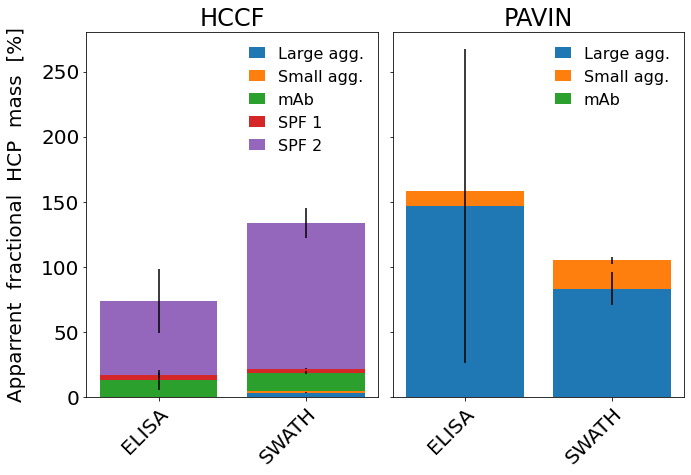

In [198]:
frac_labels = {'large':'Large agg.', 'small':'Small agg.', 'mab':'mAb', 'spf1':'SPF 1', 'spf2':'SPF 2'}

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(10, 7)
ax[0].set_ylabel('Apparrent  fractional  HCP  mass  [%]', labelpad=15)
ax[0].set_title('HCCF')
ax[1].set_title('PAVIN')
xlabels = ['ELISA', 'SWATH']
for i in [0, 1]:
    ticks = ax[i].set_xticks([0, 1], xlabels, rotation=45, ha='right', rotation_mode='anchor')

for i, feed in enumerate(['hccf', 'pavin']):
    df_temp = df_totals[(df_totals.feed == feed) & (df_totals.frac != 'feed')]
    sums = np.zeros(2)
    for frac in df_temp.frac:
        vals, errs = np.zeros(2), np.zeros(2)
        vals[0] = df_temp.loc[df_temp.frac == frac, 'hcp_mass_frac_elisa'] * 100
        vals[1] = df_temp.loc[df_temp.frac == frac, 'hcp_mass_frac_swath'] * 100
        errs[0] = df_temp.loc[df_temp.frac == frac, 'hcp_mass_frac_elisa_stdev'] * 100
        errs[1] = df_temp.loc[df_temp.frac == frac, 'hcp_mass_frac_swath_stdev'] * 100
        ax[i].bar([0, 1], vals, yerr=errs, label=frac_labels[frac], bottom=sums)
        sums[0] += vals[0]
        sums[1] += vals[1]

for i in range(2):
    ax[i].legend(handlelength=1, frameon=False, fontsize=16)
my_plot.set_layout(fig, ax)
plt.subplots_adjust(wspace=0.05)
# plt.savefig('./images/8_ELISA_vs_SWATH_HCP_mass_partitioning_stacked_bar.png', dpi=300, bbox_inches='tight')

In [199]:
df_totals

,label,feed,frac,elisa_ppm,elisa_stdev_ppm,elisa_rsd_percent,den_bradford_stdev_mg_ml,bradford_rsd_percent,digest_method,swath_ppm,...,elisa_ppm_contrib,elisa_ppm_contrib_rsd,elisa_ppm_contrib_stdev,swath_ppm_contrib,swath_ppm_contrib_rsd,swath_ppm_contrib_stdev,hcp_mass_frac_elisa_rsd,hcp_mass_frac_elisa_stdev,hcp_mass_frac_swath_rsd,hcp_mass_frac_swath_stdev
0,HCCF Feed,hccf,feed,400000.0,151718.633700,37.929658,0.241040,4.820792,native,37401.367222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HCCF Large agg.,hccf,large,127000.0,47085.079910,37.074866,0.102268,2.045369,native,186442.925701,...,833.365554,0.382284,318.582235,1223.426080,0.097508,119.293963,0.538523,0.001122,0.114482,0.003745
2,HCCF Small agg.,hccf,small,101000.0,21960.718110,21.743285,0.199342,3.986831,native,110588.105207,...,578.807535,0.217723,126.019554,633.754739,0.042863,27.164828,0.437343,0.000633,0.073726,0.001249
3,HCCF mAb,hccf,mab,162000.0,75029.087230,46.314251,0.199047,3.980937,native,16225.097508,...,52166.481007,0.463212,24164.158365,5224.729883,0.059026,308.397278,0.598692,0.078079,0.084157,0.011756
4,HCCF SPF 1,hccf,spf1,607000.0,88846.062830,14.636913,0.171472,3.429449,native,43452.695814,...,15504.898078,0.147206,2282.420583,1109.933476,0.038223,42.424958,0.406861,0.015771,0.071128,0.002111
5,HCCF SPF 2,hccf,spf2,718000.0,156156.545300,21.748822,0.034840,6.968049,standard,133538.064700,...,225285.699294,0.217512,49002.258962,41900.022686,0.081266,3405.058229,0.437238,0.246259,0.101007,0.113156
6,PAVIN Feed,pavin,feed,1510.0,860.315308,56.974524,0.158233,3.164659,native,1553.038451,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PAVIN Large agg.,pavin,large,149000.0,87284.775990,58.580387,0.547865,10.957302,native,87179.396374,...,2213.343476,0.592974,1312.454089,1295.019787,0.143622,185.993188,0.822330,1.205364,0.148495,0.123824
8,PAVIN Small agg.,pavin,small,11200.0,NaN,NaN,0.502731,10.054629,native,20802.780379,...,180.634375,NaN,NaN,335.508682,0.107873,36.192235,NaN,NaN,0.114281,0.024688
9,PAVIN mAb,pavin,mab,NaN,NaN,NaN,0.035538,0.710768,native,1.864600,...,NaN,NaN,NaN,1.782251,0.038067,0.067845,NaN,NaN,0.053597,0.000062


## If I treat the pseudo-component mass fractions for SPF2 and SPF3 as 0 in the HCCF...

In [200]:
df_mass_frac_selected.reset_index(inplace=True, drop=True)
df_mass_frac_selected.at[4, 'mass_frac'] = 0.0
df_mass_frac_selected.at[5, 'mass_frac'] = 0.0
renormalization = df_mass_frac_selected[df_mass_frac_selected.feed == 'hccf'].mass_frac.sum()
for i in range(6):
    df_mass_frac_selected.at[i, 'mass_frac'] /= renormalization

In [201]:
for i, cont in df_totals.iterrows():
    if cont.frac == 'feed':
        df_totals.at[i, 'hcp_mass_frac_elisa'] = 1.0
        df_totals.at[i, 'hcp_mass_frac_swath'] = 1.0
        total_elisa_ppm = cont.elisa_ppm
        total_swath_ppm = cont.swath_ppm
        total_elisa_rsd_percent = cont.elisa_rsd_percent
        total_swath_rsd_percent = cont.swath_rsd_percent
    else:
        mass_frac = df_mass_frac_selected.loc[(df_mass_frac_selected.feed == cont.feed) & (df_mass_frac_selected.frac == cont.frac), 'mass_frac'].iloc[0]
        mass_frac_rsd_percent = df_mass_frac_selected.loc[(df_mass_frac_selected.feed == cont.feed) & (df_mass_frac_selected.frac == cont.frac), 'rsd_percent'].iloc[0]
        df_totals.at[i, 'hcp_mass_frac_elisa'] = cont.elisa_ppm * mass_frac / total_elisa_ppm
        df_totals.at[i, 'hcp_mass_frac_elisa_rsd'] = np.sqrt((cont.elisa_rsd_percent / 100.0)**2 + (mass_frac_rsd_percent / 100.0)**2 + (total_elisa_rsd_percent / 100.0)**2)
        df_totals.at[i, 'hcp_mass_frac_elisa_stdev'] = df_totals.at[i, 'hcp_mass_frac_elisa'] * df_totals.at[i, 'hcp_mass_frac_elisa_rsd']

        df_totals.at[i, 'hcp_mass_frac_swath'] = cont.swath_ppm * mass_frac / total_swath_ppm
        df_totals.at[i, 'hcp_mass_frac_swath_rsd'] = np.sqrt((cont.swath_rsd_percent / 100.0)**2 + (mass_frac_rsd_percent / 100.0)**2 + (total_swath_rsd_percent / 100.0)**2)
        df_totals.at[i, 'hcp_mass_frac_swath_stdev'] = df_totals.at[i, 'hcp_mass_frac_swath'] * df_totals.at[i, 'hcp_mass_frac_swath_rsd']

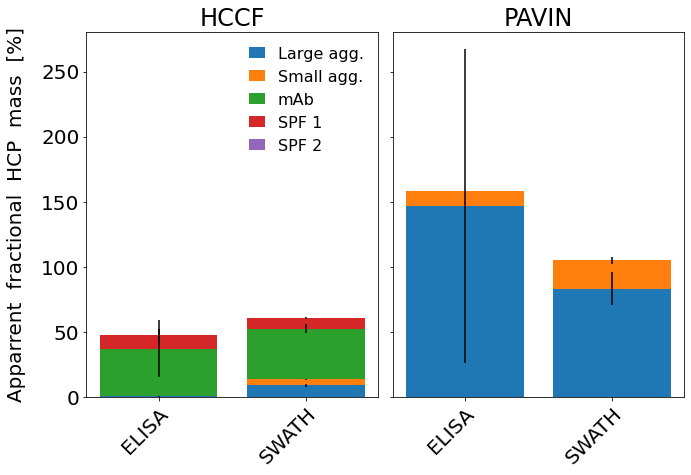

In [202]:
frac_labels = {'large':'Large agg.', 'small':'Small agg.', 'mab':'mAb', 'spf1':'SPF 1', 'spf2':'SPF 2'}

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(10, 7)
ax[0].set_ylabel('Apparrent  fractional  HCP  mass  [%]', labelpad=15)
ax[0].set_title('HCCF')
ax[1].set_title('PAVIN')
xlabels = ['ELISA', 'SWATH']
for i in [0, 1]:
    ticks = ax[i].set_xticks([0, 1], xlabels, rotation=45, ha='right', rotation_mode='anchor')

for i, feed in enumerate(['hccf', 'pavin']):
    df_temp = df_totals[(df_totals.feed == feed) & (df_totals.frac != 'feed')]
    sums = np.zeros(2)
    for frac in df_temp.frac:
        vals, errs = np.zeros(2), np.zeros(2)
        vals[0] = df_temp.loc[df_temp.frac == frac, 'hcp_mass_frac_elisa'] * 100
        vals[1] = df_temp.loc[df_temp.frac == frac, 'hcp_mass_frac_swath'] * 100
        errs[0] = df_temp.loc[df_temp.frac == frac, 'hcp_mass_frac_elisa_stdev'] * 100
        errs[1] = df_temp.loc[df_temp.frac == frac, 'hcp_mass_frac_swath_stdev'] * 100
        ax[i].bar([0, 1], vals, yerr=errs, label=frac_labels[frac], bottom=sums)
        sums[0] += vals[0]
        sums[1] += vals[1]

ax[0].legend(handlelength=1, frameon=False, fontsize=16)
my_plot.set_layout(fig, ax)
plt.subplots_adjust(wspace=0.05)
# plt.savefig('./images/8_ELISA_vs_SWATH_HCP_mass_partitioning_stacked_bar_hccf_renormalized.png', dpi=300, bbox_inches='tight')

In [203]:
df_totals

,label,feed,frac,elisa_ppm,elisa_stdev_ppm,elisa_rsd_percent,den_bradford_stdev_mg_ml,bradford_rsd_percent,digest_method,swath_ppm,...,elisa_ppm_contrib,elisa_ppm_contrib_rsd,elisa_ppm_contrib_stdev,swath_ppm_contrib,swath_ppm_contrib_rsd,swath_ppm_contrib_stdev,hcp_mass_frac_elisa_rsd,hcp_mass_frac_elisa_stdev,hcp_mass_frac_swath_rsd,hcp_mass_frac_swath_stdev
0,HCCF Feed,hccf,feed,400000.0,151718.633700,37.929658,0.241040,4.820792,native,37401.367222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HCCF Large agg.,hccf,large,127000.0,47085.079910,37.074866,0.102268,2.045369,native,186442.925701,...,833.365554,0.382284,318.582235,1223.426080,0.097508,119.293963,0.538523,0.003118,0.114482,0.010406
2,HCCF Small agg.,hccf,small,101000.0,21960.718110,21.743285,0.199342,3.986831,native,110588.105207,...,578.807535,0.217723,126.019554,633.754739,0.042863,27.164828,0.437343,0.001759,0.073726,0.003472
3,HCCF mAb,hccf,mab,162000.0,75029.087230,46.314251,0.199047,3.980937,native,16225.097508,...,52166.481007,0.463212,24164.158365,5224.729883,0.059026,308.397278,0.598692,0.216976,0.084157,0.032669
4,HCCF SPF 1,hccf,spf1,607000.0,88846.062830,14.636913,0.171472,3.429449,native,43452.695814,...,15504.898078,0.147206,2282.420583,1109.933476,0.038223,42.424958,0.406861,0.043826,0.071128,0.005866
5,HCCF SPF 2,hccf,spf2,718000.0,156156.545300,21.748822,0.034840,6.968049,standard,133538.064700,...,225285.699294,0.217512,49002.258962,41900.022686,0.081266,3405.058229,0.437238,0.000000,0.101007,0.000000
6,PAVIN Feed,pavin,feed,1510.0,860.315308,56.974524,0.158233,3.164659,native,1553.038451,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PAVIN Large agg.,pavin,large,149000.0,87284.775990,58.580387,0.547865,10.957302,native,87179.396374,...,2213.343476,0.592974,1312.454089,1295.019787,0.143622,185.993188,0.822330,1.205364,0.148495,0.123824
8,PAVIN Small agg.,pavin,small,11200.0,NaN,NaN,0.502731,10.054629,native,20802.780379,...,180.634375,NaN,NaN,335.508682,0.107873,36.192235,NaN,NaN,0.114281,0.024688
9,PAVIN mAb,pavin,mab,NaN,NaN,NaN,0.035538,0.710768,native,1.864600,...,NaN,NaN,NaN,1.782251,0.038067,0.067845,NaN,NaN,0.053597,0.000062


In [204]:
# df_totals.to_csv('./generated_tables/elisa_vs_swath_mass_distribution.csv', index=False)